# <div class="alert alert-warning" style="background-color: #90EE90; color: #90EE90;"> <center><font color="darkgreen">**Desempenho do modelo Floresta Aleatória**</font></center>
<center>Autoras: Luiza Davoli, Samarah L. M. Ramos e Sarah S. Silva</center> 
<center>˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .</center>

## Introdução
Floresta Aleatória é um modelo de aprendizado de máquina que utiliza múltiplas Árvores de Decisão para chegar a um resultado. Sendo que Árvore de Decisão é um outro tipo de modelo de aprendizado de máquina que realiza escolhas binárias com base em uma hierárquia, formando um mapa que se assemelha com uma árvore, por isso o nome, elas permitem explicar as decisões, identificar possíveis trajetos e determinar qual seria a melhor alternativa. As árvores começam por uma raiz, que não possui ramificação de entrada, depois segue para um dos nós de decisão até que chegue em um nó folha, que é um evento final, eles são os resultados possíveis dentro do conjunto de dados, dessa forma, essa estrutura permite uma melhor compreensão de como uma decisão foi tomada. 

Modelos de árvore de decisão repetem de maneira descendente e recursiva o processo de divisão dos dados até que todos tenham sido rotulados. Devido a isso, árvores muito grandes (com maior profundidade) podem ter dificuldade de rotular os dados em cada categoria, o que pode causar fragmentação de dados e até mesmo sobreajuste, assim, árvores menores são mais recomendadas pelo seu menor nível de complexidade.

A vantagem de um modelo como uma Floresta Aleatória é que o uso de diversas árvores prevê resultados mais precisos. Esse algoritmo gera um subconjunto aleatório de características, criando uma floresta com baixa correlação, isso é o principal diferencial entre uma Floresta Aleatória e uma Árvore de Decisão, pois as árvores consideram todas as possíveis divisões de características, já as florestas, selecionam apenas um subconjunto dessas características.

### Importações necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import OneHotEncoder

### Pré definido

In [2]:
SEMENTE_ALEATORIA_TESTE = 18
SEMENTE_ALEATORIA_VAL = 1001
SEMENTE_ALEATORIA_MODELO = 7
NUM_FOLDS = 3
NUM_TRIALS = 100

* SEMENTE_ALEATORIA: Garante reprodutibilidade dos resultados.
* NUM_FOLDS: Número de folds para validação cruzada.
* NUM_TRIALS: Número de tentativas para otimização com Optuna.

### Lê o data frame

In [3]:
df = pd.read_csv("dados_tratados.csv")
print(f"Dataset shape: {df.shape}")
print(f"Primeiras 5 linhas:")
print(df.head())

Dataset shape: (705, 13)
Primeiras 5 linhas:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_

Esse é o data frame escolhido para o estudo já tratado com as etapas decritas no git.

### Separando variáveis numéricas e categóricas

In [4]:
# Separando variáveis numéricas e categóricas.
numericos = df[["Age", 
                "Avg_Daily_Usage_Hours", 
                "Sleep_Hours_Per_Night", 
                "Conflicts_Over_Social_Media", 
                "Addicted_Score"]].values

categoricos = df[["Gender",
                  "Academic_Level",
                 "Country", 
                 "Most_Used_Platform",
                 "Affects_Academic_Performance",
                 "Relationship_Status"]].values

# Transformação categórico-numérica.
encoder = OneHotEncoder(sparse_output=False, drop='first')

categ_encoded = encoder.fit_transform(categoricos)

X = np.hstack([numericos, categ_encoded])

y = df["Mental_Health_Score"].values

**Estrutura dos dados:**  
- Variáveis numéricas: Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, etc.
- Variáveis categóricas: Gender, Academic_Level, Country, etc.
- Target: Mental_Health_Score (variável contínua → regressão).

### Divisão dos Dados

In [5]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=SEMENTE_ALEATORIA_TESTE  
)

X_treino_, X_val, y_treino_, y_val = train_test_split(
    X_treino, y_treino, test_size=0.1, random_state=SEMENTE_ALEATORIA_VAL 
)

**Estratégia de divisão:**
- Treino (72%): Para treinar do modelo
- Validação (8%): Dados para ajustar hiperparâmetros
- Teste (20%): Avalia o modelo final

In [6]:
# Verifique se não há overlap entre treino, teste e validação
print(f"Tamanho do dataset: {len(X)}")
print(f"Tamanho do treino: {len(X_treino_)}")
print(f"Tamanho do teste: {len(X_teste)}")
print(f"Tamanho do validação: {len(X_val)}")
print(f"Soma treino + teste + validação: {len(X_treino_) + len(X_teste) + len(X_val)}")

Tamanho do dataset: 705
Tamanho do treino: 507
Tamanho do teste: 141
Tamanho do validação: 57
Soma treino + teste + validação: 705


### Função objetivo de Otimização com Optuna
A função objetivo de um problema de otimização é a função que irá computar a métrica de interesse. Neste caso, a métrica de interesse é o RMSE médio obtido por validação cruzada.  

**Nota**: Utilizamos `neg_mean_squared_error` pois o scikit trabalha por convenção com score, ou seja, quanto maior melhor, dessa forma, para seguir essa convenção, quando se utiliza métricas de erro, coloca-se um sinal negativo.

In [7]:
def objetivo_FA(trial):

    # Cria cópias temporárias para não alterar os dados originais.
    X_temp, y_temp = X_treino_, y_treino_
    
    parametros = {
        "bootstrap": True,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error']),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20, log=True),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100)
    }
    
    modelo = RandomForestRegressor(**parametros, random_state=SEMENTE_ALEATORIA_MODELO)
    score = cross_val_score(modelo, X_temp, y_temp,
                             cv=NUM_FOLDS,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1).mean()
    
    return score

**Hiperparâmetros otimizados:**
- n_estimators: número de árvores de decisão;
- criterion: critério para medir a qualidade das divisões (erro quadrático, erro absoluto, etc.);
- max_depth: Profundidade máxima da árvore;
- min_samples_split: Mínimo de amostras para dividir um nó;
- min_samples_leaf: Mínimo de amostras nas folhas finais;
- max_features: Quantos atributos considerar em cada split.
- max_leaf_nodes: Número máximo de nós folhas.

### Otimização com Optuna

In [8]:
study = optuna.create_study(direction='maximize') 
study.optimize(objetivo_FA, n_trials=NUM_TRIALS)

print("\nMelhores hiperparâmetros:")
print(study.best_params)
print(f"Melhor MAE negativo: {study.best_value:.4f}")

[I 2025-11-03 21:01:59,789] A new study created in memory with name: no-name-eb5014b8-03fa-4f47-a676-bede6f74a9c7
[I 2025-11-03 21:02:21,039] Trial 0 finished with value: -0.1250062206986405 and parameters: {'n_estimators': 490, 'criterion': 'absolute_error', 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.3, 'max_leaf_nodes': 66}. Best is trial 0 with value: -0.1250062206986405.
[I 2025-11-03 21:02:31,275] Trial 1 finished with value: -0.10417394674084608 and parameters: {'n_estimators': 285, 'criterion': 'friedman_mse', 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_leaf_nodes': 25}. Best is trial 1 with value: -0.10417394674084608.
[I 2025-11-03 21:02:41,475] Trial 2 finished with value: -0.15009247722349614 and parameters: {'n_estimators': 295, 'criterion': 'absolute_error', 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': 0.3, 'max_leaf_nodes': 79}. Best is trial 1 with 


Melhores hiperparâmetros:
{'n_estimators': 445, 'criterion': 'absolute_error', 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_leaf_nodes': 84}
Melhor MAE negativo: -0.0297


Esse processo testa 100 combinações diferentes de hiperparâmetros e usa validação cruzada para evitar overfitting de um forma que maximiza neg_mean_absolute_error (equivale a minimizar MAE).

### Treinamento e Previsão do Modelo Final

In [9]:
best_params = study.best_params
modelo_final = RandomForestRegressor(**best_params, random_state=SEMENTE_ALEATORIA_MODELO) 
modelo_final.fit(X_treino_, y_treino_)

y_val_pred = modelo_final.predict(X_val)

O treinamento é feito com os melhores hiperparâmetros encontrados em 100 tentativas.

### Avaliação do Modelo

In [10]:
MSE_val = mean_squared_error(y_val, y_val_pred)
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(MSE_val)

print("Desempenho na validação")
print(f"MSE: {MSE_val:.4f}")
print(f"MAE: {MAE_val:.4f}")
print(f"RMSE: {RMSE_val:.4f}")

Desempenho na validação
MSE: 0.0120
MAE: 0.0424
RMSE: 0.1096


In [11]:
y_teste_pred = modelo_final.predict(X_teste)

print("Desempenho do conjunto de teste")
print(f"MSE: {mean_squared_error(y_teste, y_teste_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_teste, y_teste_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_teste, y_teste_pred)):.4f}")

Desempenho do conjunto de teste
MSE: 0.0280
MAE: 0.0593
RMSE: 0.1672


**Métricas usadas:**
- MSE (Mean Squared Error): Penaliza mais erros grandes
- MAE (Mean Absolute Error): Interpretação mais direta
- RMSE (Root Mean Squared Error): Mais fácil de visualizar por estar na mesma unidade do target

### Gráfico de dispersão: Valores Reais vs Preditos

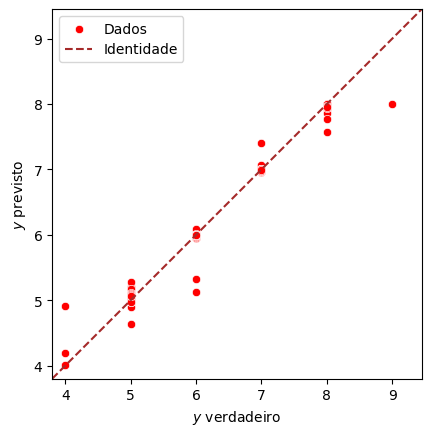

In [12]:
# definindo os valores máximos e mínimos dos eixos do gráfico
min_val = min(y_teste.min(), y_teste_pred.min())
max_val = max(y_teste.max(), y_teste_pred.max())
intervalo = [min_val * 0.95, max_val * 1.05]
 
# plotando o gráfico
eixo = sns.scatterplot(x=y_teste, y=y_teste_pred, label="Dados", color="red")
eixo.plot(intervalo, intervalo, "--", label="Identidade", color="brown")
eixo.set(
    xlabel="$y$ verdadeiro",
    ylabel="$y$ previsto",
    xlim=intervalo,
    ylim=intervalo,
    aspect="equal",
)
eixo.legend()

**Interpretação:** A dispersão em geral tem pontos próximos à linha vermelha o que indica boas previsões, todavia fica visível que os pontos com notas mais altas não são tão comuns o que indica que o modelo está subestimando os resultados.

In [13]:
MSE_teste = mean_squared_error(y_teste, y_teste_pred)
RMSE_teste = root_mean_squared_error(y_teste, y_teste_pred)
print("Resumo")
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"MSE no teste: {MSE_teste:.4f}")
print(f"RMSE no teste: {RMSE_teste:.4f}")
print(f"Número de features: {X_treino.shape[1]}")

Resumo
Melhores hiperparâmetros: {'n_estimators': 445, 'criterion': 'absolute_error', 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_leaf_nodes': 84}
MSE no teste: 0.0280
RMSE no teste: 0.1672
Número de features: 131


### Importância das Features

In [14]:
importancias = modelo_final.feature_importances_

feature_names = (['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 
                  'Conflicts_Over_Social_Media', 'Addicted_Score'] + 
                 list(encoder.get_feature_names_out(['Academic_Level', 'Country', 'Gender',
                                                   'Most_Used_Platform',
                                                   'Affects_Academic_Performance',
                                                   'Relationship_Status'])))
df_importancias = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(df_importancias.head(10))


Top 10 features mais importantes:
                              feature  importance
4                      Addicted_Score    0.357865
3         Conflicts_Over_Social_Media    0.193022
128  Affects_Academic_Performance_Yes    0.102893
1               Avg_Daily_Usage_Hours    0.100459
2               Sleep_Hours_Per_Night    0.062772
66                    Gender_Maldives    0.020741
73                       Gender_Nepal    0.018974
80                    Gender_Pakistan    0.017218
17                  Gender_Bangladesh    0.013496
51                       Gender_Italy    0.010730


### Plotar as 15 features mais importantes

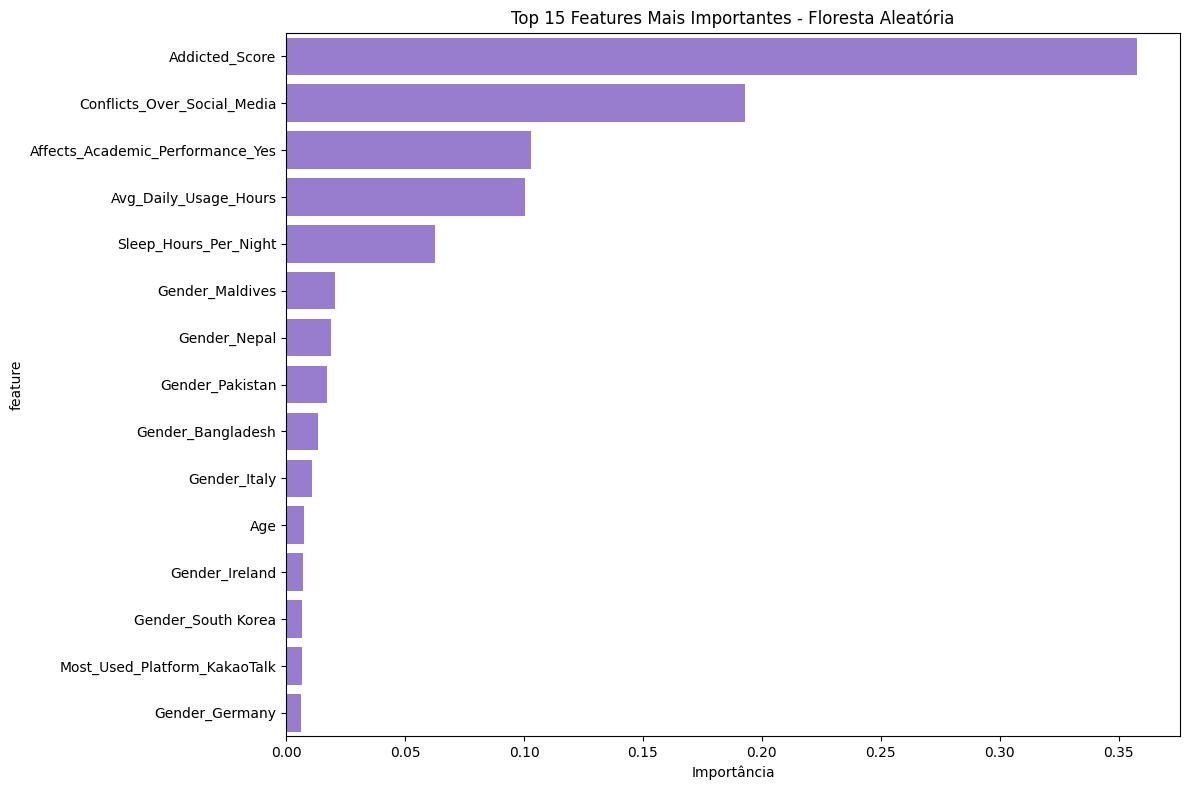

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_importancias.head(15), x='importance', y='feature', color="#9370db")
plt.title('Top 15 Features Mais Importantes - Floresta Aleatória')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

## Desempenho e Aplicabilidade do Modelo Floresta Aleatória na Predição de Saúde Mental
O modelo de Floresta Aleatória implementado nesse notebook obteve um bom desempenho, revelando sua capacidade de utilizar as variáveis fornecidas a ele para encontrar o target de saúde mental, com métricas de desempenho consistentes entre os conjuntos de validação e teste. O gráfico de dispersão apresentado demonstra que os dados estão bem distribuídos em torno do valor esperado, características de um modelo não enviesado. Além disso, ele é um modelo mais prático, por não exigir sempre que os dados sejam normalizados, como nesse caso.

## Conclusão
O uso do algoritmo Floresta Aleatória foi eficaz na predição do target e teve seu desempenho otimizado pelo Optuna para que tivesse maior eficiência. Esse modelo em comparação com um modelo de Árvore de Decisão, tem maior precisão devido ao conjunto de árvores que estruturam a base para encontrar o target.  

Ademais, esse trabalho permite utilizar parâmetros conhecidos como tempo de tela, idade e gênero para encontrar padrões e avaliar a saúde mental de um indivíduo com maior precisão.

## Salvando resultados
A fim de combinar os resultados das métricas obtidas em um único notebook, é necessário criar um arquivo que armazene todas essas informações.
 
Nesse caso, o formato utilizado será o JSON (JavaScript Object Notation), que é um formato leve de troca de dados. As vantagens de usar esse formato envolvem sua facilidade de interpretação, tanto para humanos, quanto para máquinas, sua universalidade, já que funciona com qualquer linguagem de programação e sua capacidade de ser aberto em qualquer editor.

In [16]:
import json
from datetime import datetime
import os
 
# Se o arquivo já existe, carregar. Se não, criar novo.
if os.path.exists('model_metrics.json'):
    with open('model_metrics.json', 'r') as f:
        all_models = json.load(f)
else:
    all_models = {}
 
# Adicionar novo modelo (Floresta Aleatória)
all_models['Floresta Aleatória'] = {
    'model_name': 'Árvore de Decisão',
    'mse': float(MSE_teste),
    'rmse': float(RMSE_teste),
    'mse_val': float(MSE_val),
    'rmse_val': float(RMSE_val),
    'timestamp': datetime.now().isoformat(),
    'dataset': 'dados_tratados',
    'target_variable': 'Mental_Health_Score'
}
 
# Salvar atualizado
with open('model_metrics.json', 'w') as f:
    json.dump(all_models, f, indent=4)

## Referências
[1] OPTUNA. **Optuna: A hyperparameter optimization framework**. Disponível em: <https://optuna.org/>.

[2] SCIKIT-LEARN. **sklearn.model_selection.cross_val_score**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>.

[3] SCIKIT-LEARN. **sklearn.ensemble.RandomForestRegressor**. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.apply

[5] SEABORN. **seaborn: statistical data visualization**. Disponível em: <https://seaborn.pydata.org/>.

[6] SCIKIT-LEARN. **User guide: contents — scikit-learn 0.22.1 documentation**.
Disponível em: <https://scikit-learn.org/stable/user_guide.html>. 

[7] JSON. **JSON**. Disponível em: <https://www.json.org/json-en.html>